In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_squared_error
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

# load the sales data set
sales_data = pd.read_csv('../../../../Data/SalesData.csv')
sales_data.head()

sales_data = sales_data[sales_data['Category'] == 'Skinbooster'] 


pharmacy_onehot = pd.get_dummies(sales_data['Pharmacy'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded2 = pd.concat([sales_data, pharmacy_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Product'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded3 = pd.concat([sales_data_encoded2, product_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Location'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded = pd.concat([sales_data_encoded3, product_onehot], axis=1)

sales_data_encoded


,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location,Pharmacy 1,...,"Brazil, USA, Blank, IE, Zimbabwe, Zurich",Ireland & Northern Ireland,London,"NorthEast, Midlands",NorthWest,Outside London M25,Outside London the rest,"Scotland, Newcastle",SouthEast,SouthWest
0,1-11-2015,11,4,2015,2,Injection 14,Skinbooster,Pharmacy 1,London,1,...,0,0,1,0,0,0,0,0,0,0
1,1-11-2015,11,4,2015,1,Injection 14,Skinbooster,Pharmacy 1,London,1,...,0,0,1,0,0,0,0,0,0,0
4,1-11-2015,11,4,2015,4,Injection 14,Skinbooster,Pharmacy 2,"NorthEast, Midlands",0,...,0,0,0,1,0,0,0,0,0,0
15,1-12-2015,12,4,2015,2,Injection 14,Skinbooster,Pharmacy 2,"NorthEast, Midlands",0,...,0,0,0,1,0,0,0,0,0,0
16,1-12-2015,12,4,2015,3,Injection 14,Skinbooster,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68616,1-3-2022,3,1,2022,5,Injection 10,Skinbooster,Pharmacy 5,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
68617,1-3-2022,3,1,2022,7,Injection 10,Skinbooster,Pharmacy 5,SouthWest,0,...,0,0,0,0,0,0,0,0,0,1
68618,1-3-2022,3,1,2022,2,Injection 10,Skinbooster,Pharmacy 5,SouthWest,0,...,0,0,0,0,0,0,0,0,0,1
68619,1-3-2022,3,1,2022,1,Injection 10,Skinbooster,Pharmacy 5,"NorthEast, Midlands",0,...,0,0,0,1,0,0,0,0,0,0


In [2]:
list(sales_data_encoded.columns)

['Date',
 'Month',
 'Quarter',
 'Year',
 'Qty',
 'Product',
 'Category',
 'Pharmacy',
 'Location',
 'Pharmacy 1',
 'Pharmacy 10',
 'Pharmacy 11',
 'Pharmacy 2',
 'Pharmacy 3',
 'Pharmacy 4',
 'Pharmacy 5',
 'Pharmacy 6',
 'Pharmacy 7',
 'Pharmacy 8',
 'Pharmacy 9',
 'Injection 10',
 'Injection 11',
 'Injection 14',
 'Injection 9',
 'Brazil, USA, Blank, IE, Zimbabwe, Zurich',
 'Ireland & Northern Ireland',
 'London',
 'NorthEast, Midlands',
 'NorthWest',
 'Outside London M25',
 'Outside London the rest',
 'Scotland, Newcastle',
 'SouthEast',
 'SouthWest']

In [3]:
# group the data by date and sum the quantities and category columns
sales_data_grouped = sales_data_encoded.groupby('Date').agg({
    'Qty': 'sum',
    'Pharmacy 1' : 'sum',
    'Pharmacy 2' : 'sum',
    'Pharmacy 3' : 'sum',
    'Pharmacy 4' : 'sum',
    'Pharmacy 5' : 'sum',
    'Pharmacy 6' : 'sum',
    'Pharmacy 7' : 'sum',
    'Pharmacy 8' : 'sum',
    'Pharmacy 9' : 'sum',
    'Pharmacy 10' : 'sum',
    'Pharmacy 11' : 'sum',
    'Injection 9' :'sum',
    'Injection 10' :'sum',
    'Injection 11' :'sum',
    'Injection 14' :'sum',
    'Brazil, USA, Blank, IE, Zimbabwe, Zurich' : 'sum',
    'Ireland & Northern Ireland' : 'sum',
    'London' : 'sum',
    'NorthEast, Midlands' : 'sum',
    'NorthWest' : 'sum',
    'Outside London M25' : 'sum',
    'Outside London the rest' : 'sum',
    'Scotland, Newcastle' : 'sum',
    'SouthEast' : 'sum',
    'SouthWest' : 'sum'
    					
})

# reset the index to make date a column again
sales_data_grouped = sales_data_grouped.reset_index()

# create lag features
sales_data_lagged = sales_data_grouped.copy()
for i in range(1, 8):
    sales_data_lagged[f'Qty_lag_{i}'] = sales_data_lagged['Qty'].shift(i)

# print(sales_data_lagged)

# remove rows with missing values
sales_data_lagged.dropna(inplace=True)

sales_data_lagged['Date'] = pd.to_datetime(sales_data_lagged['Date'], format='%d-%m-%Y')


#X_train, X_test, y_train, y_test = train_test_split(sales_data_lagged.loc[:,sales_data_lagged.columns!='Qty'], sales_data_lagged.loc[:,['Date', 'Qty']], test_size=0.2, random_state=42)
X = sales_data_lagged.loc[(sales_data_lagged['Date'] < '2019-10-01')]
y = sales_data_lagged.loc[(sales_data_lagged['Date'] >= '2019-10-01') & (sales_data_lagged['Date']<= '2019-12-01')]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X.loc[:,X.columns!='Qty']
X_test = y.loc[:,y.columns!='Qty']
y_train = X.loc[:,X.columns=='Qty']
y_test = y.loc[:,y.columns=='Qty']

In [4]:
y

,Date,Qty,Pharmacy 1,Pharmacy 2,Pharmacy 3,Pharmacy 4,Pharmacy 5,Pharmacy 6,Pharmacy 7,Pharmacy 8,...,"Scotland, Newcastle",SouthEast,SouthWest,Qty_lag_1,Qty_lag_2,Qty_lag_3,Qty_lag_4,Qty_lag_5,Qty_lag_6,Qty_lag_7
10,2019-10-01,369,3,29,13,4,25,3,2,3,...,7,9,6,179.0,6.0,28.0,225.0,51.0,236.0,180.0
17,2019-11-01,405,4,29,11,6,25,3,4,0,...,10,9,10,151.0,13.0,10.0,7.0,319.0,322.0,369.0
24,2019-12-01,303,2,28,13,3,15,0,2,0,...,6,5,2,104.0,1.0,5.0,5.0,367.0,195.0,405.0


In [5]:
# train an mlp classifier

# model = RandomForestRegressor(n_estimators=100, max_depth=5)
# model.fit(train_data.iloc[:, 2:], train_data['Qty'])

activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']

random_grid_mlpr = {
    'activation' : activation,
    'solver' : solver
}

# mlpr = MLPRegressor()
# mlpr_random = RandomizedSearchCV(
#     estimator=mlpr,
#     param_distributions=random_grid_mlpr,
#     n_iter=10,
#     cv=5,
#     verbose=5,
#     random_state=0
# )
mlpr = MLPRegressor()
mlpr_random = GridSearchCV(
    estimator=mlpr,
    param_grid=random_grid_mlpr,
    cv=5,
    verbose=5
)

In [6]:
mlpr_random.fit(X_train.iloc[:, 2:], y_train['Qty'])


# make predictions for the test data
predictions = mlpr_random.predict(X_test.iloc[:, 2:])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .activation=identity, solver=lbfgs;, score=0.891 total time=   0.1s
[CV 2/5] END .activation=identity, solver=lbfgs;, score=0.937 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END .activation=identity, solver=lbfgs;, score=0.965 total time=   0.1s
[CV 4/5] END .activation=identity, solver=lbfgs;, score=0.946 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWar

[CV 5/5] END .activation=identity, solver=lbfgs;, score=0.816 total time=   0.1s
[CV 1/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
c:\Users\galea\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  re

[CV 2/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 3/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 4/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END .....activation=identity, solver=sgd;, score=nan total time=   0.0s
[CV 1/5] END ..activation=identity, solver=adam;, score=0.904 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ..activation=identity, solver=adam;, score=0.991 total time=   0.0s
[CV 3/5] END ..activation=identity, solver=adam;, score=0.972 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END ..activation=identity, solver=adam;, score=0.951 total time=   0.0s
[CV 5/5] END ..activation=identity, solver=adam;, score=0.864 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .activation=logistic, solver=lbfgs;, score=0.378 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END .activation=logistic, solver=lbfgs;, score=0.646 total time=   0.4s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=logistic, solver=lbfgs;, score=-0.103 total time=   0.4s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END .activation=logistic, solver=lbfgs;, score=0.276 total time=   0.3s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, solver=lbfgs;, score=-0.190 total time=   0.4s
[CV 1/5] END ...activation=logistic, solver=sgd;, score=0.098 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ..activation=logistic, solver=sgd;, score=-0.151 total time=   0.1s
[CV 3/5] END ...activation=logistic, solver=sgd;, score=0.498 total time=   0.0s
[CV 4/5] END ...activation=logistic, solver=sgd;, score=0.342 total time=   0.1s
[CV 5/5] END ...activation=logistic, solver=sgd;, score=0.406 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END .activation=logistic, solver=adam;, score=-0.243 total time=   0.1s
[CV 2/5] END .activation=logistic, solver=adam;, score=-0.166 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END .activation=logistic, solver=adam;, score=-0.289 total time=   0.0s
[CV 4/5] END .activation=logistic, solver=adam;, score=-0.272 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END .activation=logistic, solver=adam;, score=-0.505 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .....activation=tanh, solver=lbfgs;, score=0.371 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END ....activation=tanh, solver=lbfgs;, score=-0.117 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END ....activation=tanh, solver=lbfgs;, score=-0.119 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END .....activation=tanh, solver=lbfgs;, score=0.541 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END .....activation=tanh, solver=lbfgs;, score=0.444 total time=   0.2s
[CV 1/5] END .......activation=tanh, solver=sgd;, score=0.239 total time=   0.0s
[CV 2/5] END ......activation=tanh, solver=sgd;, score=-0.111 total time=   0.0s
[CV 3/5] END .......activation=tanh, solver=sgd;, score=0.178 total time=   0.0s
[CV 4/5] END .......activation=tanh, solver=sgd;, score=0.198 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END .......activation=tanh, solver=sgd;, score=0.574 total time=   0.0s
[CV 1/5] END .....activation=tanh, solver=adam;, score=-0.204 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END .....activation=tanh, solver=adam;, score=-0.144 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END .....activation=tanh, solver=adam;, score=-0.295 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END .....activation=tanh, solver=adam;, score=-0.276 total time=   0.2s
[CV 5/5] END .....activation=tanh, solver=adam;, score=-0.470 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END .....activation=relu, solver=lbfgs;, score=0.929 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END .....activation=relu, solver=lbfgs;, score=0.935 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END .....activation=relu, solver=lbfgs;, score=0.898 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END .....activation=relu, solver=lbfgs;, score=0.967 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END .....activation=relu, solver=lbfgs;, score=0.912 total time=   0.1s
[CV 1/5] END ..activation=relu, solver=sgd;, score=-20868.281 total time=   0.0s
[CV 2/5] END activation=relu, solver=sgd;, score=-39386607417924.680 total time=   0.0s
[CV 3/5] END ...activation=relu, solver=sgd;, score=-3738.098 total time=   0.0s
[CV 4/5] END activation=relu, solver=sgd;, score=-261807570058317888.000 total time=   0.0s
[CV 5/5] END activation=relu, solver=sgd;, score=-840875726944443008.000 total time=   0.0s
[CV 1/5] END ......activation=relu, solver=adam;, score=0.800 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ......activation=relu, solver=adam;, score=0.874 total time=   0.0s
[CV 3/5] END ......activation=relu, solver=adam;, score=0.758 total time=   0.0s
[CV 4/5] END ......activation=relu, solver=adam;, score=0.768 total time=   0.0s
[CV 5/5] END ......activation=relu, solver=adam;, score=0.891 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\galea\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multi

In [7]:
# calculate the root mean squared error (RMSE) of the predictions
rmse = ((predictions - y_test['Qty']) ** 2).mean() ** 0.5
print('RMSE:', rmse)

# calculate the mean squared error
mse = mean_squared_error(y_test['Qty'], predictions)
print('MSE:', mse)

# calculate the r2 score
r2_score = r2_score(y_test['Qty'], predictions)
print('R^2 Score:', r2_score)

# calculate explained variance score
explained_variance_score = explained_variance_score(y_test['Qty'], predictions)
print('Explained Variance Score:', explained_variance_score)

# calculate max error
max_error = max_error(y_test['Qty'], predictions)
print('Max Error:', max_error)


print([X_test['Date'].values, y_test['Qty'].values, predictions])

RMSE: 51.86986558662552
MSE: 2690.4829559745986
R^2 Score: -0.5081182488646854
Explained Variance Score: 0.8460783159584774
Max Error: 65.51632574825277
[array(['2019-10-01T00:00:00.000000000', '2019-11-01T00:00:00.000000000',
       '2019-12-01T00:00:00.000000000'], dtype='datetime64[ns]'), array([369, 405, 303], dtype=int64), array([313.50334003, 339.48367425, 276.55797547])]


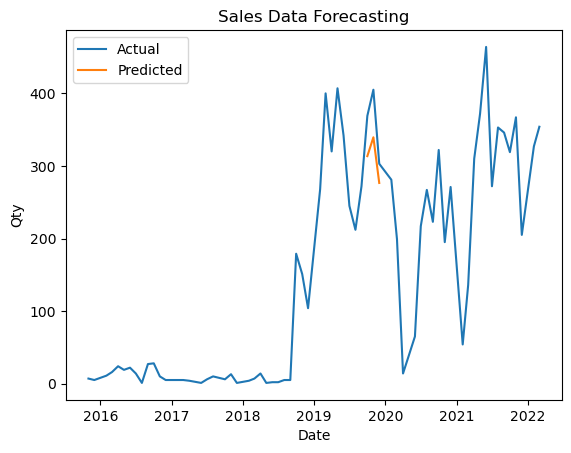

In [8]:

sales_data_lagged['predicted_quantity'] = pd.Series(predictions, index=y_test.index)
sales_data_lagged= sales_data_lagged.sort_values(by=['Date'])

# plot the actual and predicted quantities against date
plt.plot(sales_data_lagged['Date'], sales_data_lagged['Qty'], label='Actual')
plt.plot(sales_data_lagged['Date'], sales_data_lagged['predicted_quantity'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data Forecasting')
plt.legend()
plt.show()

In [9]:
mlpr_random.best_params_

{'activation': 'identity', 'solver': 'adam'}

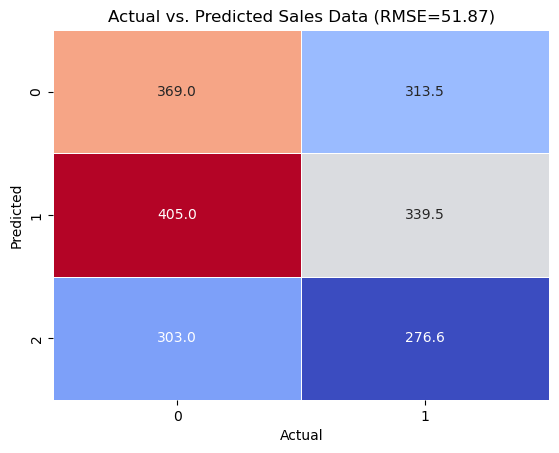

In [10]:
matrix_data = np.column_stack((y_test['Qty'].values, predictions))

# plot the matrix using seaborn's heatmap function
sns.heatmap(matrix_data, annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Sales Data (RMSE={rmse:.2f})')
plt.show()